Przygotowanie środowiska

In [609]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(6, 6))

Zaczytanie danych, wybór kolumn przy ładowaniu

In [610]:
fields = ['P_ROKDYP',"P_N","P_POZIOM", # wartosci filtrujace
"P_E_ZAR_STUD_P5","P_E_ZAR_NSTUD_P5","P_E_ZAR_P5", #dane o zarobkach absolwentow po 5 latach
"P_E_ZAR_DOSW_P5","P_E_ZAR_NDOSW_P5",
"P_ME_ZAR_P5","P_ME_ZAR_DOSW_P5","P_ME_ZAR_NDOSW_P5",
"P_ME_ZAR_STUD_P5","P_ME_ZAR_NSTUD_P5",
"P_E_ZAR_ETAT_P5","P_E_ZAR_ETAT_DOSW_P5","P_E_ZAR_ETAT_NDOSW_P5",
"P_E_ZAR_ETAT_STUD_P5","P_E_ZAR_ETAT_NSTUD_P5",
"P_ME_ZAR_ETAT_P5","P_ME_ZAR_ETAT_DOSW_P5","P_ME_ZAR_ETAT_NDOSW_P5",
"P_ME_ZAR_ETAT_STUD_P5","P_ME_ZAR_ETAT_NSTUD_P5",
"P_WWZ_STUD_P5","P_WWZ_NSTUD_P5","P_WWZ_P5","P_WWZ_DOSW_P5","P_WWZ_NDOSW_P5",
'P_NAZWA_UCZELNI',"P_NAZWA_KIERUNKU_PELNA","P_KIERUNEK_ID","P_FORMA","P_DZIEDZINA","P_WOJ"] #dane o uczelni i kierunku
data1 = pd.read_csv('dane/graduates-major-data.csv',sep=";",usecols=fields,decimal=',')

Redukcja pamieci

In [611]:
# drobna redukcja pamieci na kolumnach o pewnych wartosciach
data1["P_ROKDYP"] = data1["P_ROKDYP"].astype('int16')
data1["P_KIERUNEK_ID"] = data1["P_KIERUNEK_ID"].astype('int32')
data1["P_N"] = data1["P_N"].astype('int16')
data1["P_POZIOM"] =data1["P_POZIOM"].astype("category")
# problem z zamiana P_FORMA, przy grupowaniu powoduje memmory leak
# data1["P_FORMA"] =data1["P_POZIOM"].astype("category")
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41792 entries, 0 to 41791
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   P_ROKDYP                41792 non-null  int16   
 1   P_KIERUNEK_ID           41792 non-null  int32   
 2   P_POZIOM                41792 non-null  category
 3   P_FORMA                 41792 non-null  object  
 4   P_N                     41792 non-null  int16   
 5   P_E_ZAR_STUD_P5         2736 non-null   float64 
 6   P_E_ZAR_NSTUD_P5        7194 non-null   float64 
 7   P_E_ZAR_P5              14190 non-null  float64 
 8   P_E_ZAR_DOSW_P5         9247 non-null   float64 
 9   P_E_ZAR_NDOSW_P5        10511 non-null  float64 
 10  P_ME_ZAR_STUD_P5        2736 non-null   float64 
 11  P_ME_ZAR_NSTUD_P5       7194 non-null   float64 
 12  P_ME_ZAR_P5             14190 non-null  float64 
 13  P_ME_ZAR_DOSW_P5        9247 non-null   float64 
 14  P_ME_ZAR_NDOSW_P5     

Filtrowanie studentow po studiach magisterskich z 2014 i 2015 roku

In [612]:
# dane o absolwentach z roku 2014 i 2015 roku 
data1 = data1[(data1['P_ROKDYP']==2014) | (data1['P_ROKDYP']==2015)]
# studia magisterskie lub jednolitemagisterskie
data1 = data1[(data1['P_POZIOM']=="JM") | (data1['P_POZIOM']=="2")]

Sprawdzenie pustych wartosci

In [613]:
# duzo pustych wartosci jesli chodzi o informacje 
##### zastanowic sie nad wyborem
# -P_E_ZAR_P5, P_ME_ZAR_P5, P_WWZ_P5, maja najmniej brakujacych informacji
# P_E_ZAR_ETAT_P5,P_ME_ZAR_ETAT_P5
nullvalues = data1.isna().sum()
nullvalues[nullvalues > 0]

P_E_ZAR_STUD_P5           5013
P_E_ZAR_NSTUD_P5          3032
P_E_ZAR_P5                  16
P_E_ZAR_DOSW_P5           1541
P_E_ZAR_NDOSW_P5          1313
P_ME_ZAR_STUD_P5          5013
P_ME_ZAR_NSTUD_P5         3032
P_ME_ZAR_P5                 16
P_ME_ZAR_DOSW_P5          1541
P_ME_ZAR_NDOSW_P5         1313
P_E_ZAR_ETAT_STUD_P5      5097
P_E_ZAR_ETAT_NSTUD_P5     3037
P_E_ZAR_ETAT_P5             22
P_E_ZAR_ETAT_DOSW_P5      1677
P_E_ZAR_ETAT_NDOSW_P5     1492
P_ME_ZAR_ETAT_STUD_P5     5097
P_ME_ZAR_ETAT_NSTUD_P5    3037
P_ME_ZAR_ETAT_P5            22
P_ME_ZAR_ETAT_DOSW_P5     1677
P_ME_ZAR_ETAT_NDOSW_P5    1492
P_WWZ_STUD_P5             5013
P_WWZ_NSTUD_P5            3032
P_WWZ_P5                    16
P_WWZ_DOSW_P5             1541
P_WWZ_NDOSW_P5            1313
P_DZIEDZINA                 21
dtype: int64

Zgrupowanie danych o kierunkach z 2014 i 2015, dodanie wojewodztw tekstowych do badan

In [614]:
# zgrupowanie po kierunku na uczelni z podzialem na stacjonarne i niestacjonarne,
# liczba osob na kierunku zsumowana z lat 2014 i 2015, średnia płaca roczników uśredniona
# "P_DZIEDZINA","P_WOJ"
data1 = data1.groupby(["P_NAZWA_UCZELNI","P_KIERUNEK_ID","P_NAZWA_KIERUNKU_PELNA","P_FORMA","P_DZIEDZINA","P_WOJ"]).agg({
    "P_N" :'sum',"P_E_ZAR_P5":'mean',"P_ME_ZAR_P5":'mean',"P_E_ZAR_ETAT_P5":'mean',"P_ME_ZAR_ETAT_P5":'mean',"P_ME_ZAR_P5":'mean',"P_WWZ_P5":'mean'
})

In [615]:
# wybranie kierunkow posiadajacych conajmniej 30 absolwentow
data1 = data1[(data1['P_N']>=30)].reset_index()
# przypisanie wartosciom numerycznym wojewodztw wartosci tekstowe
wojewodztwa = {
    14:"Mazowieckie", 12:"Małopolskie", 24:"Śląskie",30:"Wielkopolskie",
    2:"Dolnoślaśkie",22:"Pomorskie",6:"Lubelskie",10:"Łódzkie",
    4:"Kujawsko-Pomorskie",32:"Zachodniopomorskie",18:"Podkarpackie",
    20:"Podlaskie",28:"Warmińsko-mazurskie",16:"Opolskie",
    26:"Świętokrzyskie", 8:"Lubuskie"
}
data1['P_WOJ']=data1['P_WOJ'].map(wojewodztwa)

In [ ]:
# DOPISEK DO PREZENTACJI, ILE MAMY DANYCH O STUDENTACH Z 2014, 2015 ORAZ W SUMIE

Udział absolwentow stac i niestac w danych

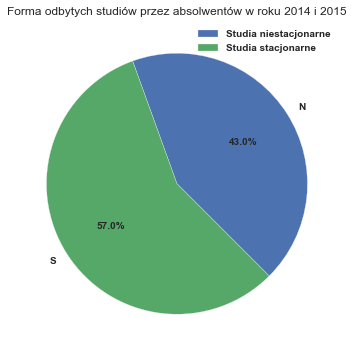

In [616]:
# Suma liczby absolwentow na studiach stacjonarnych i niestacjonarnych
formadata = data1.groupby(['P_FORMA']).agg({"P_N":"sum"})
formadata=formadata.reset_index()

plt.pie(formadata['P_N'],labels=formadata['P_FORMA'],autopct='%1.1f%%',startangle=-45)
plt.legend(['Studia niestacjonarne',"Studia stacjonarne"],loc="best")
plt.title("Forma odbytych studiów przez absolwentów w roku 2014 i 2015")
plt.savefig('Udzial1.png', dpi=400, bbox_inches='tight')
plt.show()

Udzial kierunkow w dziedzinach

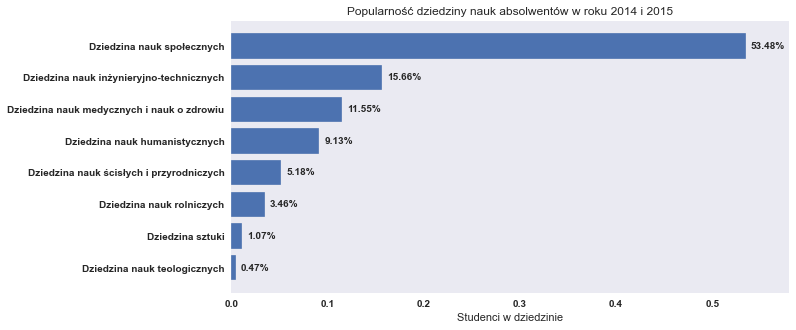

In [642]:
# zgrupowanie wedlug dziedziny i zliczenie kierunkow w tej dziedzinie
dziedzinadata = data1.groupby(["P_DZIEDZINA"])['P_N'].sum().sort_values(ascending=True)
dziedzinadata = dziedzinadata.reset_index()
dziedzinadata["P_N"] = dziedzinadata["P_N"] / dziedzinadata["P_N"].sum()
plt.figure(figsize=(10,5))
bars = plt.barh(y=dziedzinadata['P_DZIEDZINA'],width=dziedzinadata["P_N"])
plt.title("Popularność dziedziny nauk absolwentów w roku 2014 i 2015")
plt.bar_label(bars,labels=[f'{x:.2%}' for x in bars.datavalues],padding=5)
plt.xlim(right=.58)
plt.xlabel("Studenci w dziedzinie")
plt.grid(False)
plt.savefig('PopularnoscDziedzina.png', dpi=400, bbox_inches='tight')
plt.show()

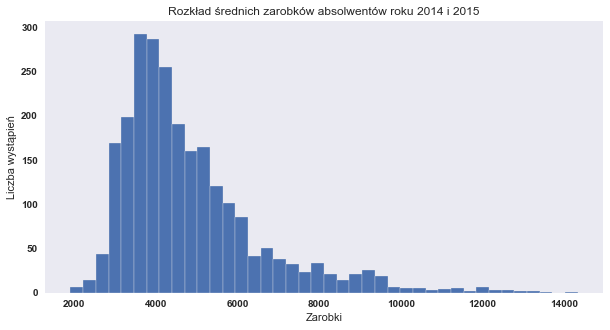

In [618]:
plt.figure(figsize=(10,5))
plt.hist(x=data1['P_E_ZAR_P5'],bins=40)
plt.title("Rozkład średnich zarobków absolwentów roku 2014 i 2015")
plt.xlabel("Zarobki")
plt.ylabel("Liczba wystąpień")
plt.grid(False)
plt.savefig('RozkładZarobkow.png', dpi=400, bbox_inches='tight')
plt.show()

In [643]:
# % absolwentow zarabiających ponizej 6K
data1[data1['P_E_ZAR_P5']<6000]['P_E_ZAR_P5'].count() / data1['P_E_ZAR_P5'].count()*100

82.02521350142334

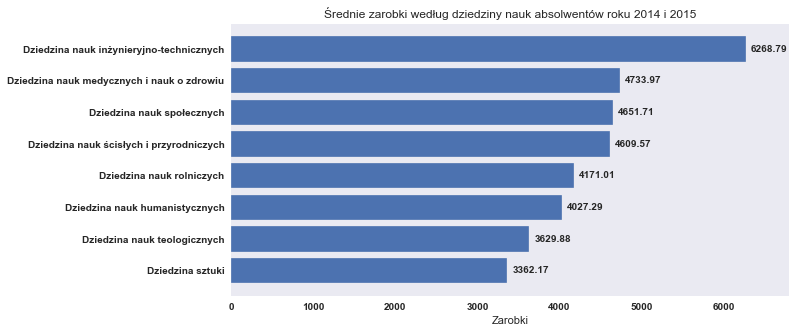

In [620]:
#srednie zarobki w dziedzinach nauk
zardziedata = data1.groupby("P_DZIEDZINA").agg({"P_E_ZAR_P5":'mean'}).sort_values(by="P_E_ZAR_P5",ascending=True)
zardziedata = zardziedata.reset_index()

plt.figure(figsize=(10,5))
bars = plt.barh(y=zardziedata['P_DZIEDZINA'],width=zardziedata["P_E_ZAR_P5"])
plt.title("Średnie zarobki według dziedziny nauk absolwentów roku 2014 i 2015")
plt.bar_label(bars,padding=5)
plt.xlim(right=6800)
plt.grid(False)
plt.xlabel("Zarobki")
plt.savefig('ZarobkiWdziedzinach.png', dpi=400, bbox_inches='tight')
plt.show()

In [622]:
bestinwoj = data1.groupby(["P_WOJ"])["P_E_ZAR_P5"].transform(max)==data1['P_E_ZAR_P5']
bestinwoj = data1[bestinwoj].sort_values("P_E_ZAR_P5",ascending=False).reset_index()
bestinwoj.index+=1
bestinwoj=bestinwoj.iloc[:,[6,1,3,8]].rename(columns={
    "P_WOJ":"Wojewodztwo",
    "P_NAZWA_UCZELNI":'Nazwa uczelni',
    "P_NAZWA_KIERUNKU_PELNA":"Nazwa kierunku",
    "P_E_ZAR_P5":"Średnie zarobki"})
bestinwoj.to_excel("bestinwoj.xlsx")
bestinwoj.head() #dla podgladu

,Wojewodztwo,Nazwa uczelni,Nazwa kierunku,Średnie zarobki
1,Małopolskie,Akademia Górniczo-Hutnicza im. Stanisława Stas...,"Informatyka, studia stacjonarne drugiego stopn...",14338.935
2,Mazowieckie,Polsko-Japońska Akademia Technik Komputerowych,"Informatyka, studia niestacjonarne drugiego st...",13197.790
3,Dolnoślaśkie,Uniwersytet Ekonomiczny we Wrocławiu,"Zarządzanie, studia niestacjonarne drugiego st...",12243.630
4,Pomorskie,Politechnika Gdańska,"Informatyka, studia stacjonarne drugiego stopn...",12109.150
5,Wielkopolskie,Politechnika Poznańska,"Informatyka, studia stacjonarne drugiego stopn...",10966.305


In [623]:
# 10 najlepszych kierunkow ze wzgleud na srednie zarobki
best10 = data1.sort_values(by="P_E_ZAR_P5",ascending=False).iloc[:10].reset_index()
best10.index+=1
best10 = best10.iloc[:,[1,3,8]].rename(columns={
    "P_NAZWA_UCZELNI":'Nazwa uczelni',
    "P_NAZWA_KIERUNKU_PELNA":"Nazwa kierunku",
    "P_E_ZAR_P5":"Średnie zarobki"})
best10.to_excel("best10.xlsx")
best10.head() #dla podgladu
# stylowania stad raczej nie zrobie z automatu suseg

,Nazwa uczelni,Nazwa kierunku,Średnie zarobki
1,Akademia Górniczo-Hutnicza im. Stanisława Stas...,"Informatyka, studia stacjonarne drugiego stopn...",14338.935
2,Akademia Górniczo-Hutnicza im. Stanisława Stas...,"Informatyka stosowana, studia stacjonarne drug...",13557.190
3,Uniwersytet Jagielloński w Krakowie,"Informatyka, studia stacjonarne drugiego stopn...",13289.935
4,Polsko-Japońska Akademia Technik Komputerowych,"Informatyka, studia niestacjonarne drugiego st...",13197.790
5,Politechnika Warszawska,"Informatyka, studia stacjonarne drugiego stopn...",13053.660
